# Exercise

try to uncover the underlying connectivity strengths in the network, you can access the data from `ntx_mvar.npy` (contains noise driven data), and `ntx_mvar_oscillation.npy` (contains oscillatory driven data). For the oscillatory driven data, compute coherence using the multitaper function and identify the oscillatory modes and connections among channels (coherence graph).

Fit and MVAR model (of order 2) in both data cases. 
You should notice that two of the nodes have high correlation.
Compute granger causality graph (ratio of variance explained by restricted and unrestricted MVAR)

Let's say you want to check if node 4 has a causal influence on node 1, then to check the strength of this causal direction you can regress node 1 once against nodes 1,2,3,4 (unrestricted case)
and once against nodes 1,2,3 (restricted case). And compute the ratio of variance explained or goodness of fit of the two models.

# Tutorial 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

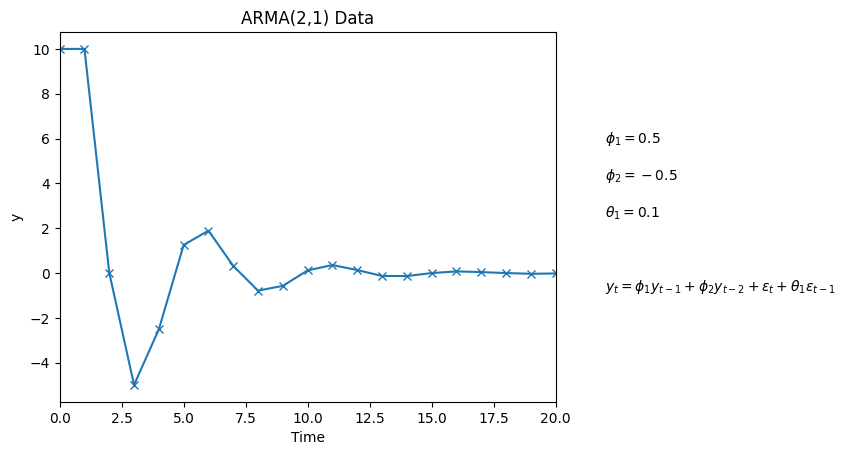

In [ ]:
# Generate ARMA(2,1) data with phi1 = 0.5, phi2 = -0.5, theta1 = 0.1
np.random.seed(1234)
n = 1000
phi = np.array([0.5, -0.5])
theta = np.array([0.1])
sigma = 0.01
mu = 0
y = 10 * np.ones(n)
e = np.random.normal(mu, sigma, n)
for i in range(2, n):
    y[i] = phi[0]*y[i-1] + phi[1]*y[i-2] + e[i] + theta[0]*e[i-1]

# Plot the data
plt.plot(y, '-x')
plt.title("ARMA(2,1) Data")
plt.xlabel("Time")
plt.ylabel("y")
plt.xlim([0, 20])

# add coefficient values to the plot using variables
# phi1, phi2, theta1, sigma
plt.text(1.1, 0.7, r'$\phi_1 =' +f'{phi[0]}'+'$', transform=plt.gca().transAxes)
plt.text(1.1, 0.6, r'$\phi_2 =' +f'{phi[1]}'+'$', transform=plt.gca().transAxes)
plt.text(1.1, 0.5, r'$\theta_1 =' +f'{theta[0]}'+'$', transform=plt.gca().transAxes)

# write the equation of the model
plt.text(1.1, 0.3, r'$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t + \theta_1 \epsilon_{t-1}$', transform=plt.gca().transAxes)
plt.show()

In [ ]:
# fit an ARIMA(2,1) model to the data
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(y, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 432.789
Date:                Sat, 25 Nov 2023   AIC                           -857.577
Time:                        14:07:47   BIC                           -837.950
Sample:                             0   HQIC                          -850.117
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5283      0.009     59.935      0.000       0.511       0.546
ar.L2         -0.9986      0.001  -1550.348      0.000      -1.000      -0.997
ma.L1          0.8632      0.016     54.994      0.0

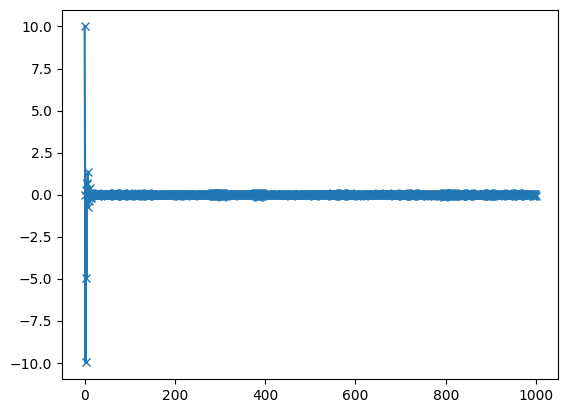

In [ ]:
# plot the residuals
plt.plot(model_fit.resid, '-x')

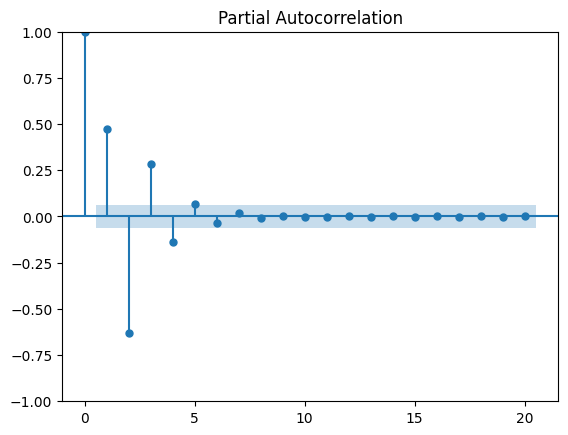

In [ ]:
# partial autocorrelation function of the signal (PACF) to determine the order of the AR model
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y, lags=20)
plt.show()

## Example Network Data

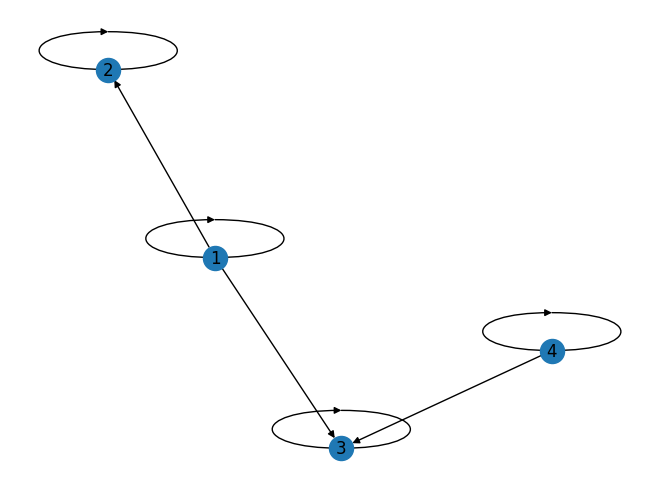

In [ ]:
# directed graph with three nodes
import networkx as nx
G = nx.DiGraph()
nvar = 4
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (1, 3), (4, 3), (1,1), (2, 2), (3,3), (4,4)])
nx.draw(G, with_labels=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# get the adjacency matrix
adj = nx.adjacency_matrix(G).todense()

# x is the state vector, 
# u is the background input - sample from 4D normal distribution with mean 0 and covariance matrix with off-diagonal elements 0.1

# define the covariance matrix
ucov = 0.9 * np.eye(4) + 0.1 * np.ones((4, 4))
sigma = 0.1

N = 1000
fs = 1000
u = np.random.multivariate_normal(np.zeros(4), ucov, N).T

# initialize the state vector
x = np.zeros((4, N))

# define the state transition matrix

def generate_A(adj):
    A = np.random.randn(4,4) * 0.7 
    A[np.where(adj==0)] = 0

    # set the diagonal elements to 0.5
    A[np.diag_indices(4)] = np.random.randn(4) * 0.2
    return A

order = 2
# generate list of `order` state transition matrices
A = [generate_A(adj.T) for i in range(order)]

# assign as edge weights in the graph
for i in range(4):
    for j in range(4):
        if adj[i, j] == 1:
            G[i+1][j+1]['weight'] = A[0][i, j]

# pure oscillation at f0 Hz assuming sampling rate of fs
f0 = 80
amp_noise = (np.random.randn(N)*0.3 + 1)
oscil_y = amp_noise * np.sin(np.sin(2*np.pi*(f0)*np.arange(N)/fs))


# iterate over time
for t in range(4, N):
    # add the oscillation to node 1
    x[0, t] += oscil_y[t]
    x[:, t] += sigma*u[:, t]
    for i in range(order):
        x[:, t] += A[i] @ x[:, t-i-1]

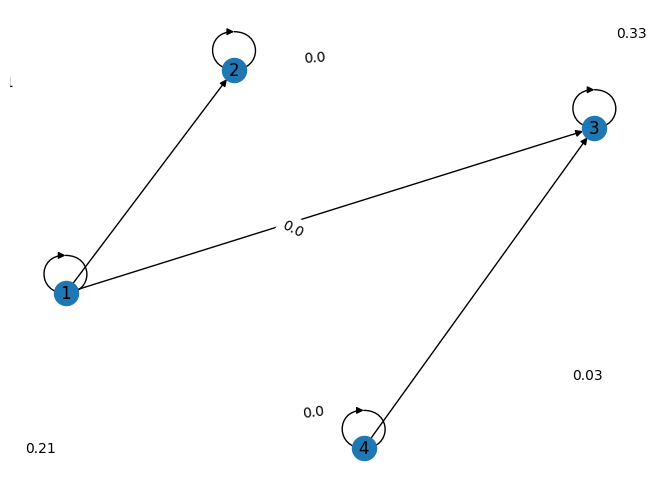

[[[ 0.11  0.    0.    0.  ]
  [ 0.   -0.3   0.    0.  ]
  [ 0.    0.    0.08  0.  ]
  [ 0.    0.    0.   -0.11]]

 [[ 0.09  0.    0.    0.  ]
  [ 0.    0.19  0.    0.  ]
  [ 0.    0.    0.4   0.  ]
  [ 0.    0.    0.   -0.1 ]]]


In [ ]:
# plot directed graph with transition matrix values on the edges
nx.draw(G, with_labels=True)
labels = nx.get_edge_attributes(G,'weight')
# round labels to 2 decimal places
labels = {k: round(v, 2) for k, v in labels.items()}
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=labels)
plt.show()

# print A with 2 decimal places
print(np.round(A, 2))


In [ ]:
# eigenvalues of A
print(np.linalg.eigvals(A))

[[ 0.11177067 -0.30431907  0.07931496 -0.11243753]
 [ 0.09463012  0.18527608  0.40412768 -0.1037067 ]]


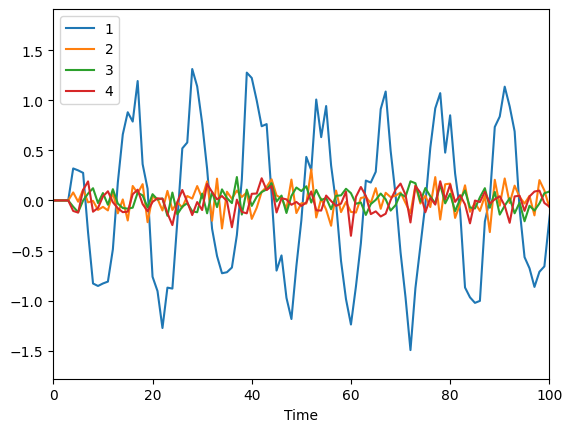

In [ ]:

# plot nodes with labels
plt.plot(x.T)
plt.legend(['1', '2', '3', '4'])
plt.xlabel("Time")
plt.xlim([0, 100])
plt.show()

## MVAR

In [ ]:
# fit MVAR model to the data

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# fit VAR model with order 2
model = VAR(x.T)
results = model.fit(2)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 25, Nov, 2023
Time:                     14:37:03
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -15.6156
Nobs:                     998.000    HQIC:                  -15.7253
Log likelihood:           2252.08    FPE:                1.38480e-07
AIC:                     -15.7925    Det(Omega_mle):     1.33595e-07
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.003093         0.011865            0.261           0.794
L1.y1         1.204956         0.027871           43.233           0.000
L1.y2        -0.134639         0.117682           -1.144           0.253
L1.y3        -0.265652

In [ ]:
# separate the parameters for each lag
k = 0
bias = results.params[0]
A_fit = []
for j in range(order):
    A_fit.append(results.params[1+k:1+k+nvar])
    k += nvar

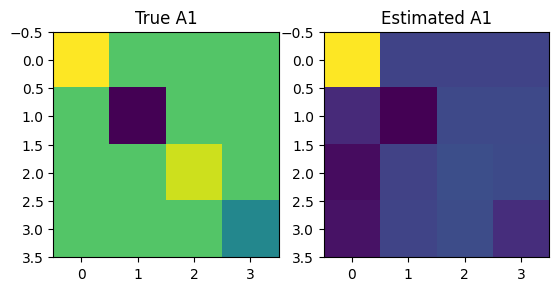

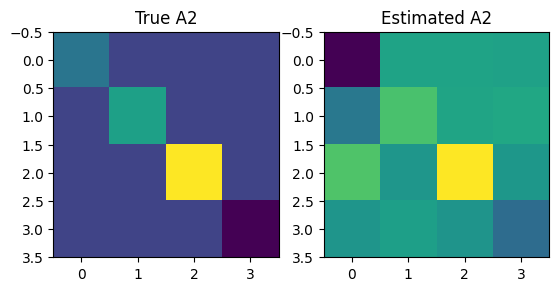

In [ ]:
# disp_A = lambda A: print(np.round(A, 2))
# plot to compare A_fit and A
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(A[0].T)
plt.title("True A1")
plt.subplot(1, 2, 2)
plt.imshow(A_fit[0])
plt.title("Estimated A1")
plt.show()

# plot to compare A_fit and A
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(A[1].T)
plt.title("True A2")
plt.subplot(1, 2, 2)
plt.imshow(A_fit[1])
plt.title("Estimated A2")
plt.show()

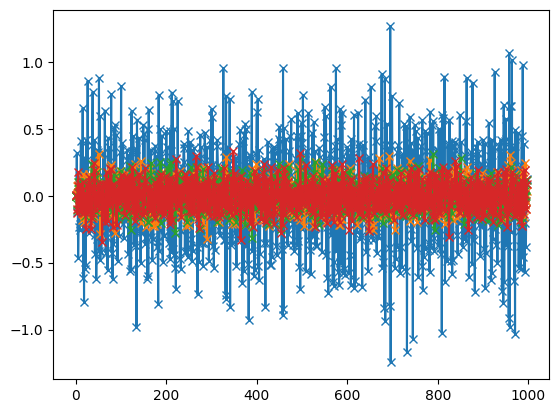

In [ ]:
# plot the residuals
plt.plot(results.resid, '-x')
plt.show()

In [ ]:
A_fit_arr = np.array(A_fit)
# pad with zeros to get 1000 samples
# Fourier transform of the MVAR coefficients
nfft = 1000
A_fit_fft = np.fft.fft(A_fit_arr, n=nfft, axis=0)

In [ ]:
# partial directed coherence (PDC) of the MVAR coefficients

identity_mat = np.repeat(np.expand_dims(np.eye(nvar), axis=0), nfft, axis=0)
A_fit_bar_fft = (identity_mat - A_fit_fft)
pdc = A_fit_bar_fft / np.sqrt((np.abs(A_fit_bar_fft)**2).sum(axis=1, keepdims=True))

In [ ]:

pdc = np.zeros_like(A_fit_fft)
for i in range(4):
    for j in range(4):
        pdc[:, i, j] = np.abs(A_fit_fft[:, i, j]) / np.sqrt(np.sum(np.abs(A_fit_fft[:, :, j])**2, axis=1))

## Coherence

### Cross-spectral density

In [ ]:
import mne.time_frequency as mnetf

# compute the spectral density matrix of the network data x

# define the frequency range
fmin = 0
fmax = 100

In [ ]:
# tapered data
# def psd_array_multitaper(x, sfreq, fmin=0.0, fmax=np.inf, bandwidth=None,
#                          adaptive=False, low_bias=True, normalization='length',
#                          output='power', n_jobs=None, verbose=None):
"""Compute power spectral density (PSD) using a multi-taper method.

Parameters
----------
x : array, shape=(..., n_times)
    The data to compute PSD from.
sfreq : float
    The sampling frequency.
fmin : float
    The lower frequency of interest.
fmax : float
    The upper frequency of interest.
bandwidth : float
    The bandwidth of the multi taper windowing function in Hz.
adaptive : bool
    Use adaptive weights to combine the tapered spectra into PSD
    (slow, use n_jobs >> 1 to speed up computation).
low_bias : bool
    Only use tapers with more than 90%% spectral concentration within
    bandwidth.
%(normalization)s
output : str
    The format of the returned ``psds`` array. Can be either ``'complex'``
    or ``'power'``. If ``'power'``, the power spectral density is returned.
    If ``output='complex'``, the complex fourier coefficients are returned
    per taper.
%(n_jobs)s
%(verbose)s

Returns
-------
psds : ndarray, shape (..., n_freqs) or (..., n_tapers, n_freqs)
    The power spectral densities. All dimensions up to the last (or the
    last two if ``output='complex'``) will be the same as input.
freqs : array
    The frequency points in Hz of the PSD.
weights : ndarray
    The weights used for averaging across tapers. Only returned if
    ``output='complex'``.

See Also
--------
mne.io.Raw.plot_psd
mne.Epochs.plot_psd
csd_multitaper
psd_multitaper

Notes
-----
.. versionadded:: 0.14.0
"""

# compute the tapered spectra
ft_ensemble, freqs, weights = mnetf.psd_array_multitaper(x, sfreq=fs, fmin=fmin, fmax=fmax, bandwidth=10, adaptive=False, low_bias=True, normalization='length', output='complex', n_jobs=1, verbose=True)

    Using multitaper spectrum estimation with 9 DPSS windows


In [ ]:
print(ft_ensemble.shape)
# 4 nodes, 9 tapers, 101 frequencies
# this is our ensemble (size 9) of fourier transforms for that data segment for each node.

(4, 9, 101)


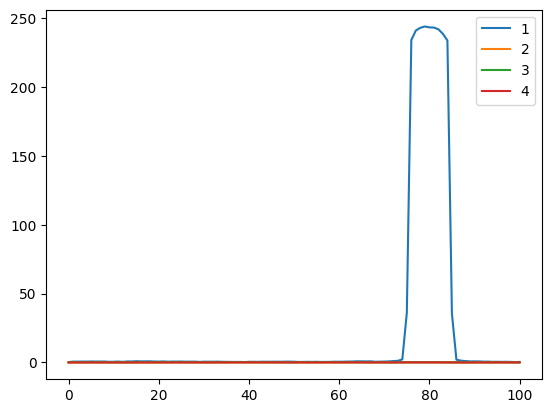

In [ ]:
# we can average over the ensemble (tapers) to get the power spectral density for each node

plt.plot((np.abs(ft_ensemble)**2 * weights).sum(axis=1).T)
plt.legend(['1', '2', '3', '4'])
plt.show()

In [ ]:
def get_psd_ensemble(ft_enemble):
    psd_ensemble = np.abs(ft_enemble)**2
    return psd_ensemble

def get_csd_ensemble(ft_enemble_x, ft_enemble_y):
    csd_ensemble_xy = np.expand_dims(ft_enemble_x, axis=1) * np.expand_dims(np.conj(ft_enemble_y), axis=0)
    return csd_ensemble_xy

def coherence(fts_x, fts_y):
    c_xy = get_csd_ensemble(fts_x, fts_y).mean(axis=2)
    psd_x = get_psd_ensemble(fts_x).mean(axis=1)
    psd_y = get_psd_ensemble(fts_y).mean(axis=1)
    psd_xy = np.expand_dims(psd_x, axis=1) * np.expand_dims(psd_y, axis=0)
    coh = c_xy/np.sqrt(psd_xy)
    return coh

In [ ]:
coh = coherence(ft_ensemble, ft_ensemble)

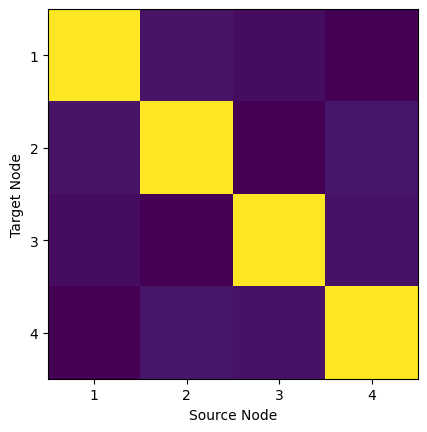

In [ ]:
plt.imshow(np.abs(coh).sum(axis=-1))
# add ticks 1 to 4
plt.xticks(np.arange(4), np.arange(1, 5))
plt.yticks(np.arange(4), np.arange(1, 5))

# add xlabel and ylabel presynaptic and postsynaptic
plt.xlabel("Source Node")
plt.ylabel("Target Node")
plt.show()

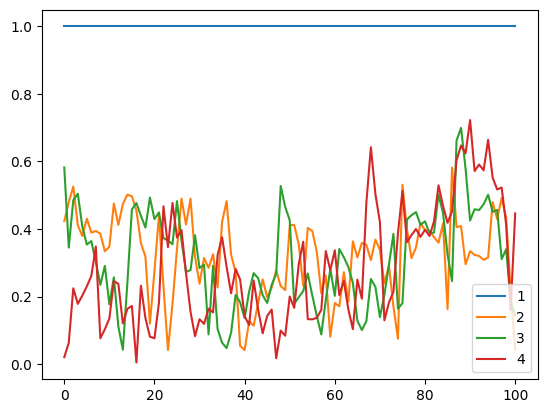

In [ ]:
plt.plot(np.abs(coh[0].T))
plt.legend(['1', '2', '3', '4'])
plt.show()

## Linear Granger Causality

uncover the directed graph using granger causality 

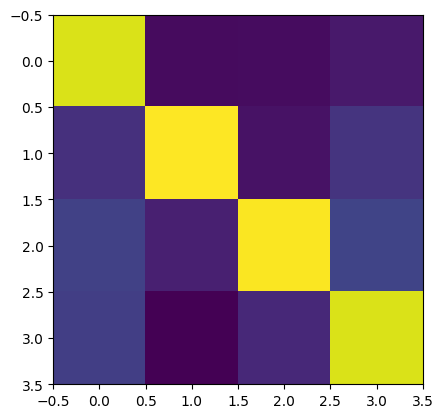

In [ ]:
plt.imshow(np.abs(pdc.sum(axis=0)))

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
granger_map = np.zeros((nvar, nvar))
for i in range(nvar):
    for j in range(nvar):
        if i!=j:
            g = grangercausalitytests(x.T[:, [i, j]], 2, addconst=True, verbose=None)
            granger_map[i, j] = g[1][0]['params_ftest'][0]
        # = g[1][0]['ssr_ftest'][1]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1327  , p=0.2875  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=1.1361  , p=0.2865  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1327  , p=0.2875  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6782  , p=0.1872  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=3.3732  , p=0.1851  , df=2
likelihood ratio test: chi2=3.3676  , p=0.1857  , df=2
parameter F test:         F=1.6782  , p=0.1872  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0519  , p=0.0080  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=7.0731  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0482  , p=0.0079  , df=1
parameter F test:         F=7.0519  , p=0.0080  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8532  , p=0.0215  

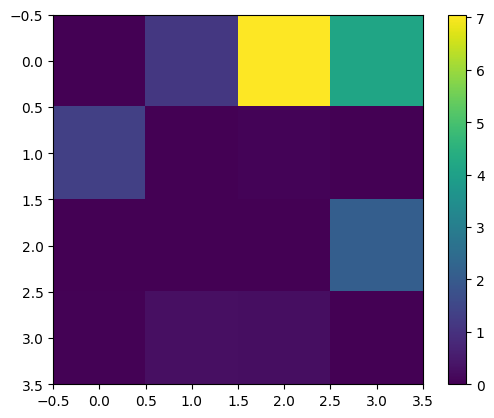

In [ ]:
im = plt.imshow(granger_map)
plt.colorbar(im)
plt.show()